In [175]:
import numpy as np
import sklearn.datasets as datasets
import matplotlib.pyplot as plt
from matplotlib import colors
import torch
import torch.functional as F 
from torch import nn



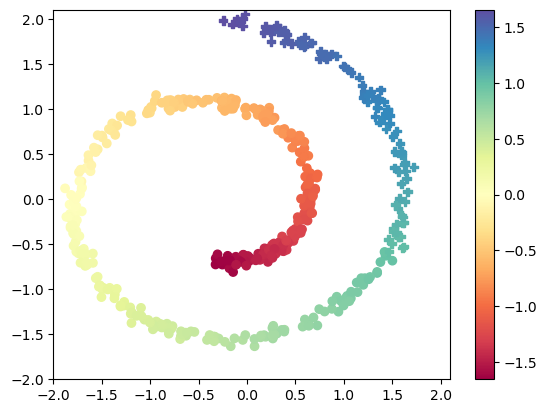

In [172]:
np.random.seed(42)

swiss_roll, t_raw = datasets.make_swiss_roll(500, noise=0.3)

def normalise(array: np.array):
    shifted = array - np.mean(array)
    scaled = shifted / np.std(array)
    return scaled 

swiss_roll = normalise(swiss_roll)
t = normalise(t_raw)
markers = {True: "o",
           False: "P"}

split = t <= 1
fig, ax = plt.subplots()

norm = colors.Normalize(vmin=t.min(), vmax=t.max())
cmap = "Spectral"

for side in (True, False):
    msk = split == side
    sc = ax.scatter(normalise(swiss_roll.T[0])[msk], 
                    normalise(swiss_roll.T[2])[msk], 
                    c=t[msk], cmap=cmap, norm=norm,
                    marker=markers[side])
    
    ax.set_xlim(-2, 2.1)
    ax.set_ylim(-2, 2.1)

fig.colorbar(sc)

t0_raw = t_raw.mean() + t_raw.std()
x0 = t0_raw * np.cos(t0_raw)
ax.axvline(x=x0, color="k", lw=1.2, ls="--", label="t = +1 threshold")

In [177]:
def cosine_beta_schedule(T=40, eps = 0.008):
    steps = torch.arange(T+1, dtype=torch.float32)
    f = lambda t: torch.cos((t/T+eps)/(1+eps) * (torch.pi / 2)) ** 2
    alphas_bars = f(steps) / f(0) 
    betas = (1 - alphas_bars[1:] / alphas_bars[:-1])
    return torch.clamp(betas, 1e-5, 0.999)

def sinusoidal_embed(t, dim=40):
    device = t.device
    half = dim // 2
    freqs = torch.exp(
        torch.arange(half, device=device) * -(torch.log(10_000.0) / (half - 1))
    )
    args = t[:, None] * freqs[None]
    return torch.cat([torch.sin(args), torch.cos(args)], dim=1)


In [178]:
class ScoreNet(nn.Module):
    def __init__(self, hidden=64, layers=5, time_dim=40):
        super().__init__()
        dims = [2 + time_dim] + [hidden] * layers + [2]
        self.linears = nn.ModuleList([nn.Linear(dims[i], dims[i+1])
                                      for i in range(len(dims)-1)])
    
    def forward(self, x, t): 
        emb = sinusoidal_embed(t.float(), self.linears[0].in_features-2)
        h = torch.cat([x, emb], dim=-1)
        for l in self.linears[:-1]:
            h = F.relu(l(h))
        return self.linears[-1](h)
    
class GuidanceNet(nn.Module):
    
    """Predicts mean μ and log-variance logσ² for regression label."""
    def __init__(self, hidden=32, layers=3, time_dim=32, dropout=0.2):
        super().__init__()
        dims = [2 + time_dim] + [hidden]*layers
        self.fcs = nn.ModuleList([nn.Linear(dims[i], dims[i+1])
                                  for i in range(len(dims)-1)])
        self.mu_head  = nn.Linear(dims[-1], 1)
        self.logvar_head = nn.Linear(dims[-1], 1)
        self.dropout = dropout
    def forward(self, x, t):
        h = torch.cat([x, sinusoidal_embed(t.float())], dim=-1)
        for fc in self.fcs:
            h = torch.sin(fc(h))
            h = F.dropout(h, p=self.dropout, training=self.training)
        return self.mu_head(h).squeeze(-1), self.logvar_head(h).squeeze(-1)



In [ ]:
def context_regulariser(model, context_x, target_mu, sigma0,
                        sigma_t=1.0, tau_t=1.0):
    """Mahalanobis penalty of Eq.(6) – (8) in the paper."""
    with torch.no_grad():
        h = torch.randn(context_x.size(0), 32, device=context_x.device)
    mu, logv = model(context_x, torch.randint_like(context_x[:,0], 1, 41))
    preds = torch.stack([mu, logv], dim=1)      # shape [M, 2]
    m  = torch.tensor([target_mu, torch.log(sigma0**2)],
                      device=context_x.device).view(1,2)
    H = h @ h.T
    cov = sigma_t * H + tau_t * torch.eye(H.size(0), device=H.device)
    inv = torch.linalg.inv(cov + 1e-5*torch.eye(H.size(0), device=H.device))
    diff = preds - m
    maha = torch.einsum('md,dd,nd->mn', diff, inv, diff).mean()
    return maha
